In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import cv2
import gc
import h5py
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Flatten, Conv2D, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [1]:
import keras
print("Keras version:", keras.__version__)
import tensorflow as tf
print("TensorFlow version:", tf.__version__)


Keras version: 3.3.3
TensorFlow version: 2.16.2


In [3]:
def moodNamePrintFromLabel(n):
  if n == 0: result = 'angry '
  elif n == 1: result = 'disgust '
  elif n == 2: result = 'fear'
  elif n == 3: result = 'happy'
  elif n == 4: result = 'sad'
  elif n == 5: result = 'surprise'
  elif n == 6: result = 'neutral'
  return result

In [4]:
def load_data(hdf5_file, dataset_name_images, dataset_name_labels):
    with h5py.File(hdf5_file, 'r') as hf:
        data = np.array(hf[dataset_name_images])
        labels = np.array(hf[dataset_name_labels])
    return data, labels

# Load data
data, labels = load_data('output files/combined_images_labels.h5', 'combined_images', 'combined_labels')

# Print shapes to verify
print(f"Data shape: {data.shape}")
print(f"Labels shape: {labels.shape}")

# Ensure that data and labels are not empty
assert len(data) > 0, "Data is empty."
assert len(labels) > 0, "Labels are empty."

# Split data
X_train, X_val, y_train, y_val = train_test_split(
    data, 
    labels, 
    test_size=0.2, 
    stratify=labels
)

# Print shapes of the split data
print(f"Training data shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Validation data shape: {X_val.shape}")
print(f"Validation labels shape: {y_val.shape}")

Data shape: (40980, 224, 224, 3)
Labels shape: (40980,)
Training data shape: (32784, 224, 224, 3)
Training labels shape: (32784,)
Validation data shape: (8196, 224, 224, 3)
Validation labels shape: (8196,)


In [5]:
# Define the data augmentation transformations
train_datagen = ImageDataGenerator(
    rotation_range=20,         # Randomly rotate images by up to 20 degrees
    width_shift_range=0.2,     # Randomly shift images horizontally by up to 20% of the width
    height_shift_range=0.2,    # Randomly shift images vertically by up to 20% of the height
    shear_range=0.2,           # Randomly apply shearing transformation
    zoom_range=0.2,            # Randomly zoom images by up to 20%
    horizontal_flip=True,      # Randomly flip images horizontally
    fill_mode='nearest'        # Strategy for filling in newly created pixels
)

# Create data generator for training data
train_generator = train_datagen.flow(
    X_train,   # Training images
    y_train,   # Training labels
    batch_size=32  # Batch size for training
)

validation_datagen = ImageDataGenerator()

# Create data generator for validation data
validation_generator = validation_datagen.flow(
    X_val,  # Validation images
    y_val,  # Validation labels
    batch_size=32   # Batch size for validation
)


In [6]:
def create_model():
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
   
    for layer in base_model.layers[:2]:  # Adjust the range as needed
        layer.trainable = False
    
    # Build the custom top layers
    model = Sequential([
        base_model,
        GlobalAveragePooling2D(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(7, activation='softmax')  # Assuming 7 emotion classes
    ])
    
    return model

# Create the model
model = create_model()

# Compile the model
model.compile(
    optimizer=Adam(),
    loss='sparse_categorical_crossentropy',  # Use 'sparse_categorical_crossentropy' if labels are integers
    metrics=['accuracy']
)


In [7]:
# Check if train_generator yields data correctly
for data_batch, label_batch in train_generator:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    break  # Only need to check one batch

# Check if validation_generator yields data correctly
for data_batch, label_batch in validation_generator:
    print(f"Data batch shape: {data_batch.shape}")
    print(f"Label batch shape: {label_batch.shape}")
    break  # Only need to check one batch


Data batch shape: (32, 224, 224, 3)
Label batch shape: (32,)
Data batch shape: (32, 224, 224, 3)
Label batch shape: (32,)


In [8]:



history = model.fit(
    train_generator,
    epochs=1,
    validation_data=validation_generator  

)


# history = model.fit(
#     train_generator,  # Data generator for training
#     epochs=5,  # Number of epochs
#     validation_data=validation_generator  # Data generator for validation
# )


e:\Thesis 2\Code\myenv\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1025/1025 ━━━━━━━━━━━━━━━━━━━━ 2070s 2s/step - accuracy: 0.3361 - loss: 1.7273 - val_accuracy: 0.2925 - val_loss: 1.9537


In [9]:
# model.save_weights('output files/my_model.weights.h5') 


In [10]:
# # Create and compile the model
# new_model = create_model()

# # Load the weights
# try:
#     new_model.load_weights('output files/my_model.weights.h5')
#     print("Weights loaded successfully!")
# except ValueError as e:
#     print(f"Error loading weights: {e}")

# new_model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [11]:
model.save('output files/my_model.keras')


In [12]:
loaded_model = tf.keras.models.load_model('output files/my_model.keras')


In [13]:

import urllib.request

# URL to download the Haar cascade XML file
url = 'https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml'

# Path to save the downloaded XML file
xml_file_path = 'haarcascade_frontalface_default.xml'

# Download the XML file
urllib.request.urlretrieve(url, xml_file_path)

print("Haar cascade XML file downloaded successfully.")


Haar cascade XML file downloaded successfully.


In [17]:
import cv2
from PIL import Image
import matplotlib.pyplot as plt


face_casecade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')


def videoToMoodDetection(video_path):
  #video_cap = cv2.VideoCapture(0)
  video_cap = cv2.VideoCapture(video_path)

  while (video_cap.isOpened()):
    ret, frame = video_cap.read()

    Gray_img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    faces = face_casecade.detectMultiScale(Gray_img, 1.3, 5)

    for (x, y, w, h) in faces:
      single_face = Gray_img[y:y+h, x:x+w]  # Extract face region

      # Convert single_face to RGB if it is grayscale
      if len(single_face.shape) == 2:  # Check if the image is grayscale
        single_face = cv2.cvtColor(single_face, cv2.COLOR_GRAY2RGB)

      resized_img = cv2.resize(single_face, (224, 224), interpolation=cv2.INTER_AREA)
      #printing the 48*48 pixel images which will be passed to the model
      plt.imshow(resized_img, cmap='gray')
      plt.show()

      #resize for passing to the model
      resized_img = np.reshape(resized_img, (1, 224, 224, 3)) / 255.0

      #passing to model
      result = np.argmax(loaded_model.predict(resized_img), axis=-1)
      if result is not None:
        print(moodNamePrintFromLabel(result))



def imageToMoodDetection(img_path):

  img = cv2.imread(img_path)

  Gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

  faces = face_casecade.detectMultiScale(Gray_img, 1.3, 3)

  for (x, y, w, h) in faces:
    single_face = Gray_img[y:y+h, x:x+w]  # Extract face region

    # Convert single_face to RGB if it is grayscale
    if len(single_face.shape) == 2:  # Check if the image is grayscale
      single_face = cv2.cvtColor(single_face, cv2.COLOR_GRAY2RGB)

    resized_img = cv2.resize(single_face, (224, 224), interpolation=cv2.INTER_AREA)
    plt.imshow(resized_img)
    plt.show()      
    print(resized_img.shape)
    resized_img = np.reshape(resized_img, (1, 224, 224, 3)) / 255.0

      #passing to model
    result = np.argmax(loaded_model.predict(resized_img), axis=-1)
    if result is not None:
      print(moodNamePrintFromLabel(result))



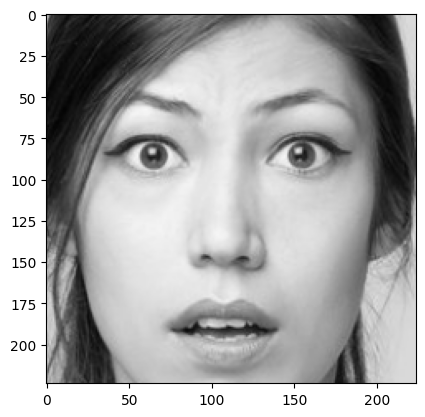

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 974ms/step
happy


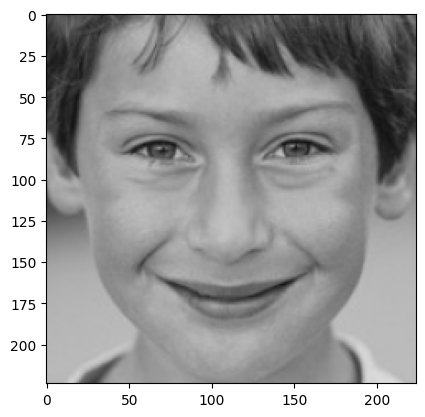

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
happy


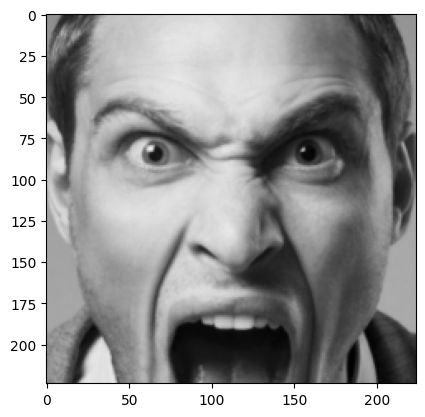

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
happy


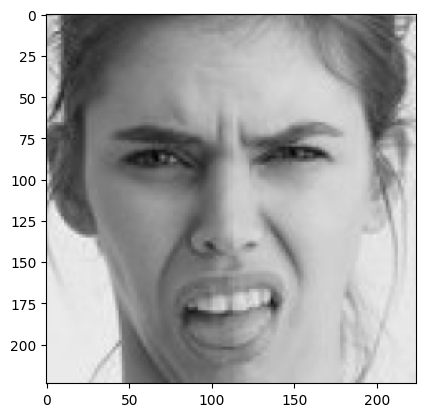

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
happy


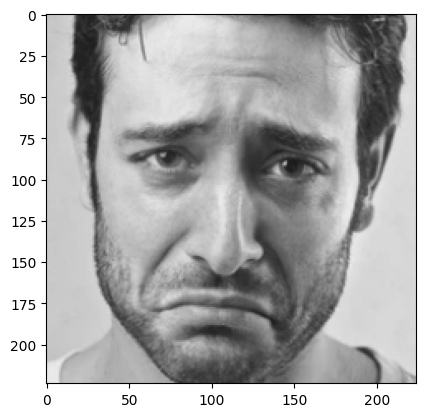

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
happy


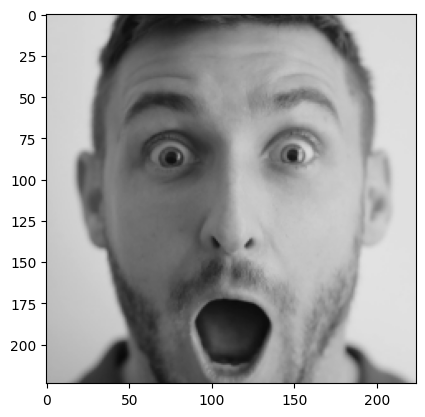

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
happy


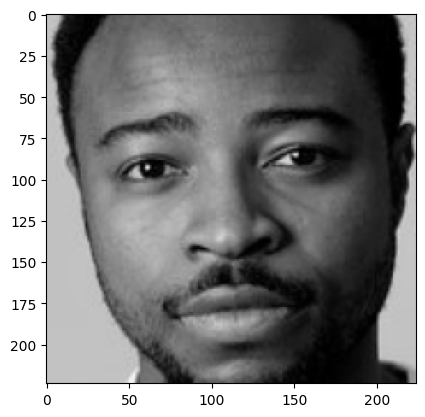

(224, 224, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
happy


In [18]:
import cv2

# Load the image
imageToMoodDetection('Test image/Testing1.jpg')
imageToMoodDetection('Test image/Testing2.jpg')
imageToMoodDetection('Test image/Testing3.jpg')
imageToMoodDetection('Test image/Testing4.jpg')
imageToMoodDetection('Test image/Testing5.webp')
imageToMoodDetection('Test image/Testing6.jpg')
imageToMoodDetection('Test image/Testing7.jpg')





